# Задание 6. Различные реализации редукции
Необходимо реализовать операцию редукции следующими способами:
- С использованием критической секции
- С использованием атомарных операций
- С использованием замков.
Полученные реализации сравнить с директивой `reduction`.

В качестве целевой задачи будет использовано суммирование элементов массива.

## Описание подходов
Все описанные алгоритмы находятся в модуле [`reductions`](../../reductions/reductions.c).

### Использование критической секции

```c
static int arraySumReductionCritical(int *array, int length)
{
    int total = 0;
    int i;
    int chunkSize;
    int start;
    int end;
#pragma omp parallel shared(array, length, chunkSize, total) private(i, start, end)
    {
        int sum = 0;
        chunkSize = length / omp_get_num_threads();
        start = omp_get_thread_num() * chunkSize;
        end = omp_get_thread_num() == omp_get_num_threads() - 1
                  ? length
                  : start + chunkSize;
        for (i = start; i < end; i++)
        {
            sum += array[i];
        }
#pragma omp critical
        {
            total += sum;
        }
    }
    return total;
}
```

### Использование атомарных операций

```c
static int arraySumReductionAtomics(int *array, int length)
{
    int total = 0;
    int i;
    int chunkSize;
    int start;
    int end;
#pragma omp parallel shared(array, length, chunkSize, total) private(i, start, end) default(none)
    {
        int sum = 0;
        chunkSize = length / omp_get_num_threads();
        start = omp_get_thread_num() * chunkSize;
        end = omp_get_thread_num() == omp_get_num_threads() - 1
                  ? length
                  : start + chunkSize;
        for (i = start; i < end; i++)
        {
            sum += array[i];
        }
#pragma omp atomic
        total += sum;
    }
    return total;
}
```

### Использование замков
```c
static int arraySumReductionLocks(int *array, int length)
{
    int total = 0;
    int i;
    int chunkSize;
    int start;
    int end;
    omp_lock_t lock;
    omp_init_lock(&lock);
#pragma omp parallel shared(array, length, chunkSize, total) private(i, start, end)
    {
        int sum = 0;
        chunkSize = length / omp_get_num_threads();
        start = omp_get_thread_num() * chunkSize;
        end = omp_get_thread_num() == omp_get_num_threads() - 1
                  ? length
                  : start + chunkSize;
        for (i = start; i < end; i++)
        {
            sum += array[i];
        }
        omp_set_lock(&lock);
        total += sum;
        omp_unset_lock(&lock);
    }
    return total;
    omp_destroy_lock(&lock);
}
```

### Использование директивы reduction
В данном подходе использована редукция с оператором `+`. 
```c
static int arraySumReductionBuiltin(int *array, int length)
{
    int sum = 0;
#pragma omp parallel for shared(array) reduction(+ \
                                                 : sum)
    for (int i = 0; i < length; i++)
    {
        sum += array[i];
    }
    return sum;
}
```

## Сравнение эффективности алгоритмов
Для сравнения алгоритмов были произведены замеры времени их работы на массивов, состоящих из 10, 100 и 10000 элементов. Было проведено 30 экспериментов, их результаты сохранены в файле [output.csv](./output.csv). 
Первые 10 строк таблицы представлены ниже.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

dataset = pd.read_csv("output.csv", sep=';')
lengths = {100: "small", 10000: "medium", 1000000: "large"}
dataset = dataset.astype({'method': 'category',  'length': 'category'})
dataset['length'] = dataset['length'].replace(lengths)
print(dataset.head(10))


     method  num_threads length  elapsed_time
0   builtin            2  small        0.0369
1  critical            2  small        0.0011
2   atomics            2  small        0.0007
3     locks            2  small        0.0008
4   builtin            3  small        0.0291
5  critical            3  small        0.0011
6   atomics            3  small        0.0006
7     locks            3  small        0.0010
8   builtin            4  small        0.0367
9  critical            4  small        0.0011


Рассчитаем среднее время работы каждого из описанных подходов при каждом из имеющихся размеров массивов.

In [2]:
means_for_critical = dataset[dataset['method'] == 'critical'][['length', 'elapsed_time']].groupby('length').agg({'elapsed_time': 'mean'}).sort_values('length')
means_for_atomics = dataset[dataset['method'] == 'atomics'][['length', 'elapsed_time']].groupby('length').agg({'elapsed_time': 'mean'}).sort_values('length')
means_for_locks = dataset[dataset['method'] == 'locks'][['length', 'elapsed_time']].groupby('length').agg({'elapsed_time': 'mean'}).sort_values('length')
means_for_builtin = dataset[dataset['method'] == 'builtin'][['length', 'elapsed_time']].groupby('length').agg({'elapsed_time': 'mean'}).sort_values('length')

In [3]:
def visualize(ylabel, title, data):
    labels = lengths.keys()
    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x - 3*width/2, data['builtin'],
                    width, label='Встроенная редукция')
    rects2 = ax.bar(x - width/2, data['critical'],
                    width, label='Критическая секция')
    rects3 = ax.bar(x + width/2, data['atomics'], width,
                    label='Атомарная операция')
    rects4 = ax.bar(x + 3*width/2, data['locks'],
                    width, label='Замки')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Размер массива')
    ax.set_xticks(x, labels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.15f'))
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects4, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()


Визуализируем данные. Построим гистограмму среднего времени работы каждого из подходов для каждого из доступных размеров массивов. 

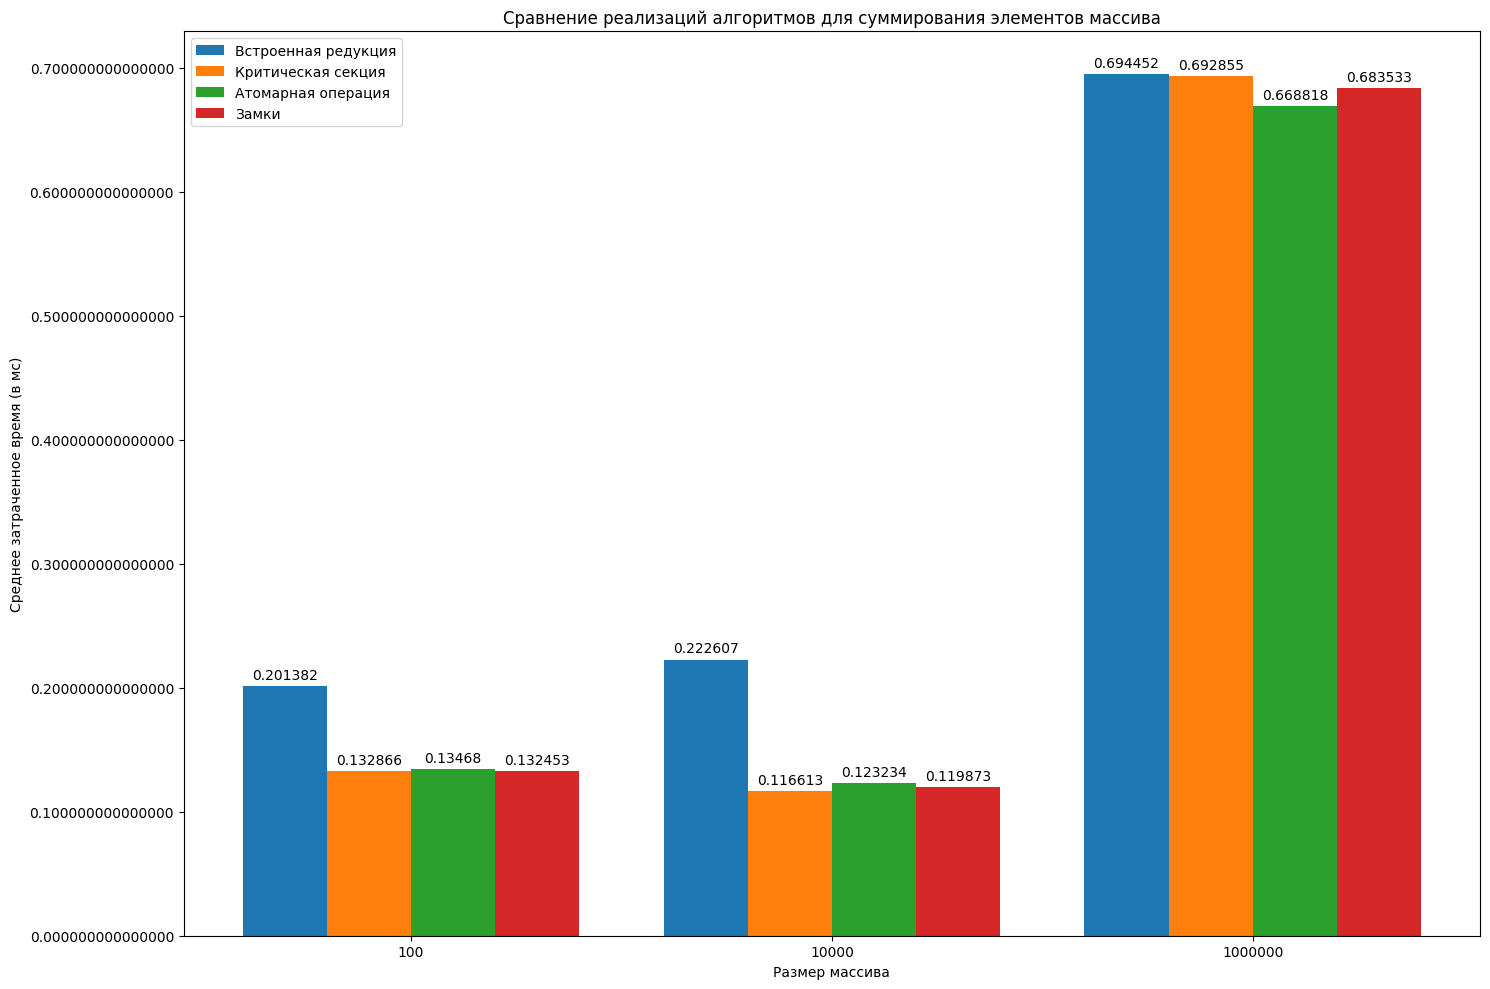

In [4]:
mean_data = {
    "atomics":  means_for_atomics['elapsed_time'],
    "builtin": means_for_builtin['elapsed_time'],
    "critical":  means_for_critical['elapsed_time'],
    "locks":  means_for_locks['elapsed_time']
}
visualize('Среднее затраченное время (в мс)',
          'Сравнение реализаций алгоритмов для суммирования элементов массива', mean_data)


Легко заметить, что применение многопоточности оправдано лишь массивов большого размера. Для них все 3 метода в среднем работают примерно в 4 раза быстрее, чем однопоточная программа. Далее рассмотрим зависимость ускорения от числа потоков для каждого из имеющихся размеров массивов.

In [5]:
means_by_threads = dataset.groupby(
    ['num_threads', 'length', 'method']).agg({'elapsed_time': 'mean'}).sort_values('num_threads')

means_by_threads = means_by_threads[means_by_threads['elapsed_time'].notnull(
)].reset_index()


In [6]:
def visualize_boost(data, filters, title):
    labels = dataset.num_threads.unique()
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 5))
    bfsa_critical = plt.plot(
        x, data.loc[filters['critical'], 'elapsed_time'], label='Критическая секция')
    bfsa_atomics = plt.plot(
        x, data.loc[filters['atomics'], 'elapsed_time'], label='Атомарная операция')
    bfsa_builtin = plt.plot(
        x, data.loc[filters['locks'], 'elapsed_time'], label='Замки')
    bfsa_builtin = plt.plot(
        x, data.loc[filters['builtin'], 'elapsed_time'], label='Встроенная редукция')

    ax.set_xticks(x, labels)
    ax.set_title(title)
    ax.set_xlabel('Количество потоков')
    ax.set_ylabel('Время работы (мс)')
    ax.grid()
    ax.legend()
        

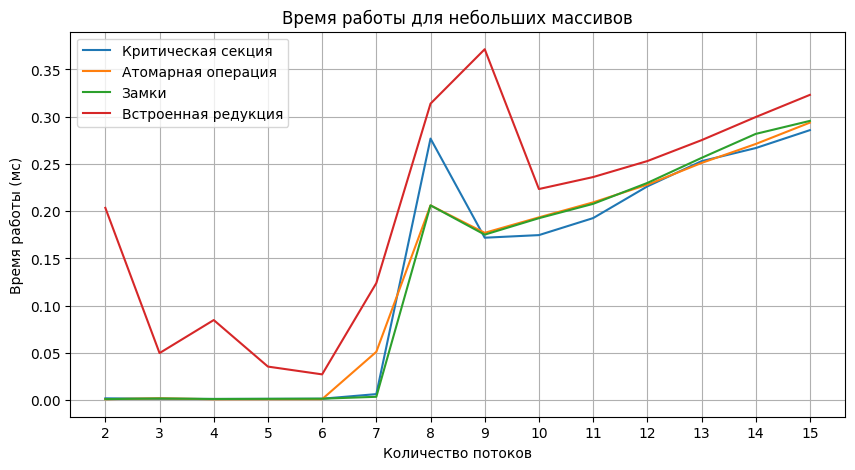

In [7]:
filters_for_small_arrays = {
    'critical': (means_by_threads['method'] == 'critical') & (means_by_threads['length'] == 'small'),
    'locks': (means_by_threads['method'] == 'locks') & (means_by_threads['length'] == 'small'),
    'atomics': (means_by_threads['method'] == 'atomics') & (means_by_threads['length'] == 'small'),
    'builtin': (means_by_threads['method'] == 'builtin') & (means_by_threads['length'] == 'small')
}
visualize_boost(means_by_threads, filters_for_small_arrays, 'Время работы для небольших массивов')

Как мы можем заметить, все реализации редукции оказываются быстрее встроенного алгоритма.

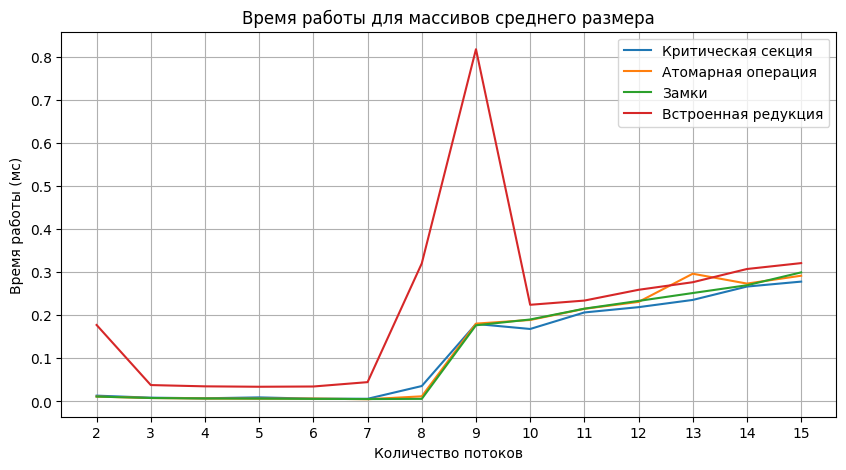

In [8]:
filters_for_medium_arrays = {
    'critical': (means_by_threads['method'] == 'critical') & (means_by_threads['length'] == 'medium'),
    'locks': (means_by_threads['method'] == 'locks') & (means_by_threads['length'] == 'medium'),
    'atomics': (means_by_threads['method'] == 'atomics') & (means_by_threads['length'] == 'medium'),
    'builtin': (means_by_threads['method'] == 'builtin') & (means_by_threads['length'] == 'medium')
}
visualize_boost(means_by_threads, filters_for_medium_arrays, 'Время работы для массивов среднего размера')

Для массивов среднего размера получилась картина, аналогичная предыдущему случаю.

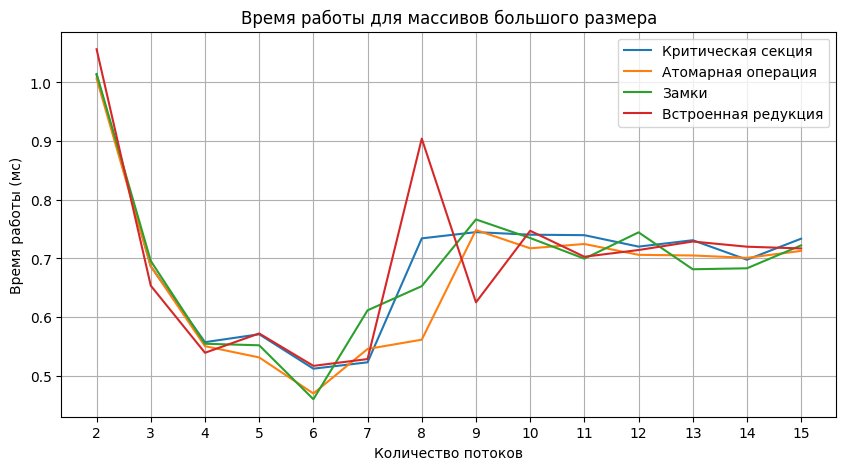

In [9]:
filters_for_large_arrays = {
    'critical': (means_by_threads['method'] == 'critical') & (means_by_threads['length'] == 'large'),
    'locks': (means_by_threads['method'] == 'locks') & (means_by_threads['length'] == 'large'),
    'atomics': (means_by_threads['method'] == 'atomics') & (means_by_threads['length'] == 'large'),
    'builtin': (means_by_threads['method'] == 'builtin') & (means_by_threads['length'] == 'large')
}
visualize_boost(means_by_threads, filters_for_large_arrays,
                'Время работы для массивов большого размера')


Для больших массивов все алгоритмы показали примерно одинаковые результаты. 

Заметим некий общий для всех размеров массивов тренд. Алгоритм с критической секцией работает медленнее алгоритма с атомарными операциями, который, в свою очередь, уступает по скорости алгоритмам с замками. Встроенная реализация редукции работает быстрее прочих реализаций лишь при больших размерах массива. В остальных случаях она оказывается медленнее.